In [1]:
!pip install scikit-learn matplotlib seaborn underthesea tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00


In [2]:
!pip install imblearn

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Reshape, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import Concatenate, Flatten, Dropout, Dense, BatchNormalization, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load your cleaned data
df = pd.read_csv('/content/drive/MyDrive/ChongPha_Ver2/Dataset_ChongPha.csv')

# Combine text columns
df['text'] = df['comment_clean']

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

print(f"Data shape: {df.shape}")
print(f"Labels: {label_encoder.classes_}")
print(f"Label distribution:\n{df['label'].value_counts()}")

Data shape: (18912, 6)
Labels: ['KHONG_LIEN_QUAN' 'KHONG_PHAN_DONG' 'PHAN_DONG']
Label distribution:
label
KHONG_LIEN_QUAN    10004
KHONG_PHAN_DONG     6744
PHAN_DONG           2164
Name: count, dtype: int64


In [8]:
class SimpleVocab:
    def __init__(self, texts, max_vocab):
        # Tokenize all texts
        all_words = []
        for text in texts:
            words = word_tokenize(str(text.lower()))
            all_words.extend(words)

        # Build vocabulary
        word_counts = Counter(all_words)
        vocab_words = [word for word, count in word_counts.most_common(max_vocab-2)]

        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        for i, word in enumerate(vocab_words):
            self.word2idx[word] = i + 2

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, text, max_len=100):
        words = word_tokenize(str(text))
        indices = [self.word2idx.get(word, 1) for word in words]

        # Pad or truncate
        if len(indices) < max_len:
            indices += [0] * (max_len - len(indices))
        else:
            indices = indices[:max_len]

        return indices

In [9]:
# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['encoded_label'].tolist(),
    test_size=0.2, random_state=2025, stratify=df['encoded_label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=2025, stratify=temp_labels
)

# Build vocabulary
vocab = SimpleVocab(train_texts, max_vocab=13000)

# Create datasets
X_train = np.array([vocab.encode(text, max_len=256) for text in train_texts])
X_val = np.array([vocab.encode(text, max_len=256) for text in val_texts])
X_test = np.array([vocab.encode(text, max_len=256) for text in test_texts])

print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")

Vocabulary size: 13000
Train: 15129, Val: 1891, Test: 1892


In [10]:
# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [11]:
from imblearn.over_sampling import SMOTE

# Method 1: SMOTE oversampling
smote = SMOTE(random_state=2025)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(Counter(y_smote))


Class distribution after SMOTE:
Counter({np.int64(1): 8003, np.int64(0): 8003, np.int64(2): 8003})


In [34]:
model = None
# Define parameters
vocab_size = len(vocab.word2idx)
embedding_dim = 256
max_len = 256  # sequence length
num_filters = 100
filter_sizes = [3, 4, 5]
num_classes = 3

with tf.device('/CPU:0'):
    # Input and embedding layers
    inputs = Input(shape=(max_len,), dtype='int32')
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

    # Parallel Conv1D layers (no reshape needed)
    conv_0 = Conv1D(filters=num_filters, kernel_size=filter_sizes[0], activation='relu')(embedding_layer)
    conv_1 = Conv1D(filters=num_filters, kernel_size=filter_sizes[1], activation='relu')(embedding_layer)

    # Global max pooling
    pool_0 = GlobalMaxPooling1D()(conv_0)
    pool_1 = GlobalMaxPooling1D()(conv_1)

    concatenated = Concatenate()([pool_0, pool_1])

    # Flatten and add dropout
    flatten = Flatten()(concatenated)

    #Dense
    # x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flatten)
    # x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)

    # x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flatten)
    # x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)

    # Output layer
    outputs = Dense(units=num_classes, activation='softmax')(flatten)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile with Adam optimizer
    adam = Adam(learning_rate=1e-4)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 256, 256)  │  3,328,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 254, 100)  │     76,900 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 253, 100)  │    102,500 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_12[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_13[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 200)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 200)       │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │        603 │ flatten_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,508,003 (13.38 MB)

 Trainable params: 3,508,003 (13.38 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
with tf.device('/CPU:0'):
    history = model.fit(X_train, y_train, epochs=10,
                        validation_data=(X_val, y_val),
                        batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.5066 - loss: 0.9770 - val_accuracy: 0.6182 - val_loss: 0.8494
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6492 - loss: 0.7989 - val_accuracy: 0.6779 - val_loss: 0.7458
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7076 - loss: 0.6863 - val_accuracy: 0.6959 - val_loss: 0.7097
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7499 - loss: 0.6128 - val_accuracy: 0.7039 - val_loss: 0.6903
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7780 - loss: 0.5552 - val_accuracy: 0.7044 - val_loss: 0.6860
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8019 - loss: 0.5083 - val_accuracy: 0.7049 - val_loss: 0.6892
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8328 - loss: 0.4488 - val_accuracy: 0.7039 - val_loss: 0.7005


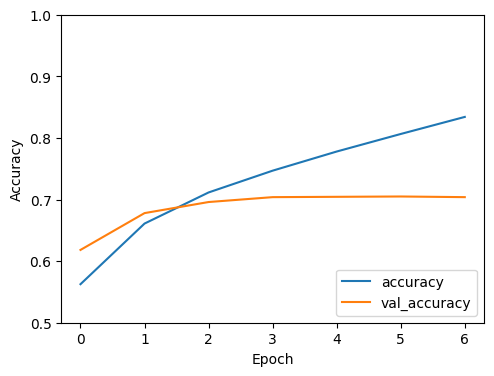

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Report:
                 precision    recall  f1-score   support

KHONG_LIEN_QUAN       0.76      0.82      0.79      1001
KHONG_PHAN_DONG       0.66      0.68      0.67       675
      PHAN_DONG       0.58      0.32      0.42       216

       accuracy                           0.71      1892
      macro avg       0.67      0.61      0.62      1892
   weighted avg       0.70      0.71      0.70      1892



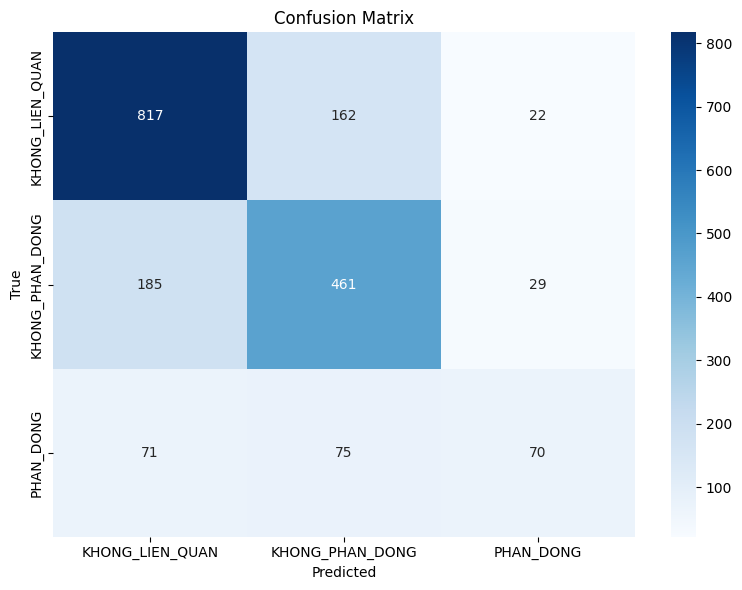

In [36]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

with tf.device('/CPU:0'):
    # Generate predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['KHONG_LIEN_QUAN', 'KHONG_PHAN_DONG', 'PHAN_DONG']))

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['KHONG_LIEN_QUAN', 'KHONG_PHAN_DONG', 'PHAN_DONG'],
                yticklabels=['KHONG_LIEN_QUAN', 'KHONG_PHAN_DONG', 'PHAN_DONG'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()


In [22]:
model = None
# Define parameters
vocab_size = len(vocab.word2idx)
embedding_dim = 256
max_len = 256  # sequence length
lstm_units = 128
num_classes = 3

# Input and embedding layers
inputs = Input(shape=(max_len,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Add spatial dropout to prevent overfitting in embedding layer
spatial_dropout = SpatialDropout1D(0.2)(embedding_layer)

lstm_output = Bidirectional(LSTM(96, dropout=0.3, recurrent_dropout=0.3))(spatial_dropout)
x = Dense(96, activation='relu')(lstm_output)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Output layer
outputs = Dense(units=num_classes, activation='softmax')(x)

# Create and compile the model
model = Model(inputs=inputs, outputs=outputs)

# Compile with Adam optimizer
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 256, 256)       │     3,328,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 256, 256)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 192)            │       271,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,617,923 (13.80 MB)

 Trainable params: 3,617,923 (13.80 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
with tf.device('/CPU:0'):
    history = model.fit(X_train, y_train, epochs=10,
                        validation_data=(X_val, y_val),
                        batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 154s 325ms/step - accuracy: 0.5453 - loss: 0.9470 - val_accuracy: 0.6219 - val_loss: 0.8685
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 151s 318ms/step - accuracy: 0.6413 - loss: 0.8452 - val_accuracy: 0.6748 - val_loss: 0.7760
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 151s 319ms/step - accuracy: 0.7013 - loss: 0.7328 - val_accuracy: 0.6716 - val_loss: 0.7619
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 151s 319ms/step - accuracy: 0.7196 - loss: 0.6954 - val_accuracy: 0.6848 - val_loss: 0.7458
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 152s 322ms/step - accuracy: 0.7358 - loss: 0.6399 - val_accuracy: 0.6875 - val_loss: 0.7438
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 150s 318ms/step - accuracy: 0.7682 - loss: 0.5885 - val_accuracy: 0.7007 - val_loss: 0.7248
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 150s 317ms/step - accuracy: 0.7854 - loss: 0.5491 - val_accuracy: 0.7028 - val_loss: 0.7375
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 152s 321ms/step - accuracy: 0.7998 -

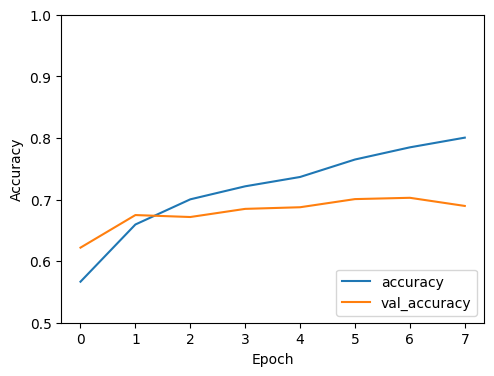

60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step

Classification Report:
                 precision    recall  f1-score   support

KHONG_LIEN_QUAN       0.75      0.81      0.78      1001
KHONG_PHAN_DONG       0.64      0.63      0.63       675
      PHAN_DONG       0.51      0.35      0.41       216

       accuracy                           0.69      1892
      macro avg       0.63      0.60      0.61      1892
   weighted avg       0.68      0.69      0.69      1892



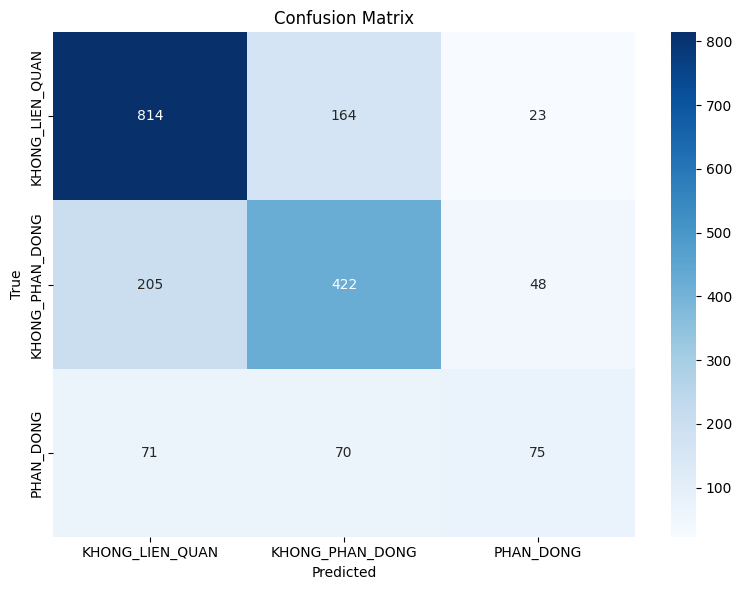

In [25]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

with tf.device('/CPU:0'):
    # Generate predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['KHONG_LIEN_QUAN', 'KHONG_PHAN_DONG', 'PHAN_DONG']))

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['KHONG_LIEN_QUAN', 'KHONG_PHAN_DONG', 'PHAN_DONG'],
                yticklabels=['KHONG_LIEN_QUAN', 'KHONG_PHAN_DONG', 'PHAN_DONG'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
